<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#导入相应模块" data-toc-modified-id="导入相应模块-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>导入相应模块</a></span></li><li><span><a href="#定义相关函数" data-toc-modified-id="定义相关函数-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>定义相关函数</a></span></li><li><span><a href="#构建数据结构" data-toc-modified-id="构建数据结构-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>构建数据结构</a></span><ul class="toc-item"><li><span><a href="#构建因子数据结构" data-toc-modified-id="构建因子数据结构-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>构建因子数据结构</a></span></li><li><span><a href="#构建股票价格数据结构" data-toc-modified-id="构建股票价格数据结构-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>构建股票价格数据结构</a></span></li><li><span><a href="#清洗数据" data-toc-modified-id="清洗数据-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>清洗数据</a></span></li></ul></li><li><span><a href="#因子分析" data-toc-modified-id="因子分析-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>因子分析</a></span><ul class="toc-item"><li><span><a href="#因子收益分析" data-toc-modified-id="因子收益分析-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>因子收益分析</a></span><ul class="toc-item"><li><span><a href="#分组平均绝对收益" data-toc-modified-id="分组平均绝对收益-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>分组平均绝对收益</a></span></li><li><span><a href="#分组平均超额收益" data-toc-modified-id="分组平均超额收益-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>分组平均超额收益</a></span></li><li><span><a href="#因子分组累计绝对收益净值曲线" data-toc-modified-id="因子分组累计绝对收益净值曲线-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>因子分组累计绝对收益净值曲线</a></span></li><li><span><a href="#因子分组累计超额收益净值曲线" data-toc-modified-id="因子分组累计超额收益净值曲线-4.1.4"><span class="toc-item-num">4.1.4&nbsp;&nbsp;</span>因子分组累计超额收益净值曲线</a></span></li><li><span><a href="#因子收益：因子加权的（多空）累计收益净值曲线" data-toc-modified-id="因子收益：因子加权的（多空）累计收益净值曲线-4.1.5"><span class="toc-item-num">4.1.5&nbsp;&nbsp;</span>因子收益：因子加权的（多空）累计收益净值曲线</a></span></li><li><span><a href="#多空对冲累计收益净值曲线（非因子加权）" data-toc-modified-id="多空对冲累计收益净值曲线（非因子加权）-4.1.6"><span class="toc-item-num">4.1.6&nbsp;&nbsp;</span>多空对冲累计收益净值曲线（非因子加权）</a></span></li></ul></li><li><span><a href="#因子IC分析" data-toc-modified-id="因子IC分析-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>因子IC分析</a></span><ul class="toc-item"><li><span><a href="#IC统计表" data-toc-modified-id="IC统计表-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>IC统计表</a></span></li><li><span><a href="#因子IC时序图" data-toc-modified-id="因子IC时序图-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>因子IC时序图</a></span></li><li><span><a href="#因子IC分布图与QQ图" data-toc-modified-id="因子IC分布图与QQ图-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>因子IC分布图与QQ图</a></span></li></ul></li><li><span><a href="#因子换手率分析" data-toc-modified-id="因子换手率分析-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>因子换手率分析</a></span></li></ul></li></ul></div>

<font size=6 face="黑体">**SmartQ因子检验**</font>

# 导入相应模块

In [1]:
%pylab inline --no-import-all
import pandas as pd
import numpy as np
import alphalens
import datetime
import os
import tushare as ts

Populating the interactive namespace from numpy and matplotlib


/Users/davidyujun/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 定义相关函数

In [2]:
class Cache(object):
    """缓存类"""
    def __init__(self, maxsize=100):
        self.cache = {}
        self.order = []     # least recently used first
        self.maxsize = maxsize

    def get(self, key):
        try:
            item = self.cache[key]  # KeyErroe if not present
            self.order.remove(key)
            self.order.append(key)
        except KeyError:
            item = None
        return item

    def set(self, key, value):
        if key in self.cache:
            self.order.remove(key)
        elif len(self.cache) >= self.maxsize:
            # discard least recently used item
            del self.cache[self.order.pop(0)]
        self.cache[key] = value
        self.order.append(key)

    def size(self):
        return len(self.cache)

In [7]:
utils_trading_days = pd.Series()
ts_conn = ts.get_apis()
df_SZZS = ts.bar(code='000001', conn=ts_conn, asset='INDEX')
ts.close_apis(ts_conn)
utils_trading_days = pd.Series(df_SZZS.index).sort_values()

def get_trading_days(start=None, end=None, ndays=None, ascending=True):
    """
    取得交易日列表，分三种方式取得
    （1）指定开始、结束日期，即start和end不为None，此时忽略参数ndays
    （2）指定开始日期和天数，即start和ndays不为None，而end为None
    （3）指定结束日期和天数，即end和ndays为None，而start为None
    --------
    :param start: datetime-like or str
        开始日期，格式：YYYY-MM-DD
    :param end: datetime-like or str
        结束日期，格式：YYYY-MM-DD
    :param ndays: int
        交易日天数
    :param ascending: bool，默认True
        是否升序排列
    :return:
    --------
        Series of pandas.Timestamp，交易日列表，默认按交易日升序排列
    """
    if start is not None and end is not None:
        trading_days = utils_trading_days[(utils_trading_days >= start) & (utils_trading_days <= end)]
    elif start is not None and ndays is not None:
        trading_days = utils_trading_days[utils_trading_days >= start].iloc[:ndays]
    elif end is not None and ndays is not None:
        trading_days = utils_trading_days[utils_trading_days <= end].iloc[-ndays:]
    elif start is not None:
        trading_days = utils_trading_days[utils_trading_days >= start]
    elif end is not None:
        trading_days = utils_trading_days[utils_trading_days <= end]
    elif ndays is not None:
        trading_days = utils_trading_days[-ndays:]
    else:
        trading_days = utils_trading_days
    trading_days = trading_days.reset_index(drop=True)
    if not ascending:
        trading_days = trading_days.sort_values(ascending=False)
    return trading_days
# ------------------------------------
def to_date(date_like):
    if isinstance(date_like, datetime.datetime) or isinstance(date_like, datetime.date):
        return date_like
    else:
        return datetime.datetime.strptime(date_like.replace('-', ''), '%Y%m%d')
# -------------------------------------
def is_month_end(trading_day):
    """
    是否时月末的交易日
    :param trading_day: datetime-like, str
    :return: bool
    """
    trading_day = to_date(trading_day)
    trading_days = get_trading_days(start=trading_day, ndays=2)
    if trading_day != trading_days[0]:
        return False
    else:
        if trading_day.month == trading_days[1].month:
            return False
        else:
            return True
# ------------------------------------
MKT_DAILY_FQ_HEADER = ['code', 'date', 'open', 'high', 'low', 'close', 'vol', 
                       'amount', 'turnover1', 'turnover2', 'factor']
DataCache = Cache(3000)
def is_normal_traded(code, trading_day):
    """
    个股在指定交易日是否正常交易
    """
    daily_mkt_path = '/Users/davidyujun/Dropbox/FactorDB/ElementaryFactor/mkt_daily_FQ/%s.csv' % code
    if not os.path.isfile(daily_mkt_path):
        return False
    key = '%s_daily_mkt_%s' % (code, to_date(trading_day).strftime('%Y%m%d'))
    df_daily_mkt = DataCache.get(key)
    if df_daily_mkt is None:
        df_daily_mkt = pd.read_csv(daily_mkt_path, 
                                   names=MKT_DAILY_FQ_HEADER, 
                                   parse_dates=[1],
                                   header=0)
        DataCache.set(key, df_daily_mkt)
    
    if len(df_daily_mkt[df_daily_mkt.date==to_date(trading_day)]) > 0:
        return True
    else:
        return False

6609   1990-12-19
6608   1990-12-20
6607   1990-12-21
6606   1990-12-24
6605   1990-12-25
Name: datetime, dtype: datetime64[ns]

# 构建数据结构

## 构建因子数据结构

In [10]:
start_date = '2012-12-31'
end_date = '2016-09-30'
# 取得开始结束日期间的交易日数据
trading_days = get_trading_days(start_date, end_date)
# 遍历交易日数据，如果是月末，则读取SmartQ因子载荷值
factor_data = pd.DataFrame()
for trading_day in trading_days:
    if is_month_end(trading_day):
        factor_data_path = '/Users/davidyujun/Dropbox/FactorDB/Sentiment/SmartQ_%s.csv' % trading_day.strftime('%Y%m%d')
        factor_data = factor_data.append(pd.read_csv(factor_data_path,
                                                     parse_dates=[0],
                                                     names=['date','factor','asset'],
                                                     header=0),ignore_index=True)
# 遍历factor_data，剔除在调仓日没有正常交易的个股（如停牌等）
ind_to_be_deleted = []
for ind, factor_info in factor_data.iterrows():
    if not is_normal_traded(factor_info.asset, factor_info.date):
        ind_to_be_deleted.append(ind)
factor_data = factor_data.drop(ind_to_be_deleted, axis=0)
# 对factor_data进行层次化索引,level0=date,level1=asset
factor_data = factor_data.set_index(['date','asset'])

NameError: name 'factor_head' is not defined

In [19]:
factor_data.head()

factor
date       asset             
2012-12-31 SZ000009  0.995160
           SZ000001  0.994420
           SZ000027  1.001902
           SZ000046  0.969262
           SZ000061  0.995410

## 构建股票价格数据结构

In [17]:
dates = list(factor_data.index.levels[0])
dates.append(pd.Timestamp('2016-10-31'))
codes = list(factor_data.index.levels[1])
prices = pd.DataFrame(np.zeros((len(dates),len(codes))), columns=codes, index=dates)
prices.index.name = 'Date'
mkt_header = ['code', 'date', 'open', 'high', 'low', 'close', 'vol', 'amount', 'turnover1', 'turnover2', 'factor']
for date in dates:
    for code in codes:
        mkt_data_path = '/Users/davidyujun/Dropbox/FactorDB/ElementaryFactor/mkt_daily_FQ/%s.csv' % code
        df_mkt_data = pd.read_csv(mkt_data_path, parse_dates=[1], names=mkt_header, header=0)
        if len(df_mkt_data[df_mkt_data.date==date]) == 0:
            if len(df_mkt_data[df_mkt_data.date<=date]) == 0:
                prices.loc[date,code] = 0.0
            else:
                prices.loc[date,code] = df_mkt_data[df_mkt_data.date<=date].iloc[-1].close
        else:
            prices.loc[date,code] = df_mkt_data[df_mkt_data.date==date].iloc[0].open
prices.head()

,SH600000,SH600004,SH600006,SH600007,SH600008,SH600009,SH600010,SH600011,SH600012,SH600015,...,SZ300508,SZ300509,SZ300510,SZ300511,SZ300512,SZ300513,SZ300515,SZ300516,SZ300518,SZ300519
Date,,,,,,,,,,,,,,,,,,,,,
2012-12-31,66.5670,10.4028,10.3520,17.9198,14.6251,33.7880,15.8575,24.4193,7.1231,18.9226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-31,77.6155,11.3030,11.2205,18.3132,15.1993,36.0570,15.5622,22.6446,7.4080,21.5648,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02-28,72.8508,10.7865,10.7341,18.1716,18.7796,35.3189,14.6172,22.8931,7.2656,20.2809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-03-29,69.2600,10.1963,9.9004,18.0929,26.7846,36.5764,15.7689,24.3128,7.0519,18.8482,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-04-26,68.7767,10.2110,10.0741,16.5668,25.9401,34.9362,14.1743,23.2125,6.9984,19.4064,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 清洗数据

In [23]:
smartq_factor = alphalens.utils.get_clean_factor_and_forward_returns(factor_data,
                                                                     prices,
                                                                     quantiles=5,
                                                                     periods=(1,))
smartq_factor.head()

Dropped 0.0% entries from factor data (0.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


1    factor  factor_quantile
date       asset                                        
2012-12-31 SH600000  0.165976  1.000525                4
           SH600004  0.086534  0.997451                3
           SH600006  0.083897  0.997870                3
           SH600007  0.021953  0.995016                1
           SH600008  0.039261  0.995372                2

In [96]:
date_label = datetime.datetime(2012,12,31)
q_factor = smartq_factor.loc[date_label]
q_factor = q_factor[q_factor.factor_quantile==1]
# print(q_factor['factor'].sum())
# print(q_factor.shape)
factor1_ret = 0.0
for _, factor_info in q_factor.iterrows():
    factor1_ret += factor_info[1] * factor_info.factor
# factor1_ret /= len(q_factor)
factor1_ret /= q_factor['factor'].sum()
print('factor return of quantile 2 at %s = %.6f' % (date_label.strftime('%Y-%m-%d'), factor1_ret))

factor return of quantile 2 at 2012-12-31 = 0.073166


In [94]:
# date_label = datetime.datetime(2013,4,26)
q_factor = smartq_factor.loc[date_label]
# print(q_factor.shape)
factor2_ret = 0.0
for _, factor_info in q_factor.iterrows():
    factor2_ret += factor_info[1] * factor_info.factor
# factor2_ret /= len(q_factor)
factor2_ret /= q_factor['factor'].sum()
print('mean factor return at %s = %.6f' % (date_label.strftime('%Y-%m-%d'), factor2_ret))
print('factor demeaned return of quantile 2 at %s = %.6f' % (date_label.strftime('%Y-%m-%d'), factor1_ret-factor2_ret))

mean factor return at 2013-01-31 = 0.016168
factor demeaned return of quantile 2 at 2013-01-31 = 0.001292


In [127]:
date_label = datetime.datetime(2012,12,31)
q_factor = smartq_factor.loc[date_label]
mean_factor = q_factor['factor'].mean()
# print((q_factor['factor']-mean_factor).head())
# print(q_factor['factor'].sum())
factor1_ret = 0.0
for _, factor_info in q_factor.iterrows():
    factor1_ret += factor_info[1] * (factor_info.factor-mean_factor)
# factor1_ret /= len(q_factor)
factor1_ret /= (q_factor['factor']-mean_factor).abs().sum()
print('factor return of quantile 2 at %s = %.6f' % (date_label.strftime('%Y-%m-%d'), factor1_ret))

factor return of quantile 2 at 2012-12-31 = -0.008073


# 因子分析 

## 因子收益分析

In [25]:
mean_return_by_q, std_err_by_q = alphalens.performance.mean_return_by_quantile(smartq_factor,
                                                                               by_date=False,
                                                                               by_group=False,
                                                                               demeaned=False)
mean_return_by_q_demeaned, std_err_by_q = alphalens.performance.mean_return_by_quantile(smartq_factor,
                                                                                        by_date=False,
                                                                                        by_group=False,
                                                                                       demeaned=True)

### 分组平均绝对收益

In [26]:
mean_return_by_q

,1
factor_quantile,
1,0.038526
2,0.035666
3,0.031895
4,0.026524
5,0.022184


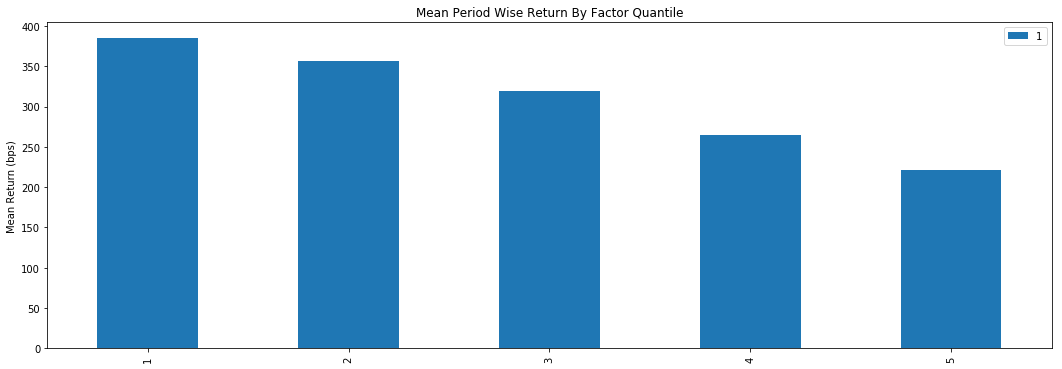

In [27]:
alphalens.plotting.plot_quantile_returns_bar(mean_return_by_q)

### 分组平均超额收益

In [28]:
mean_return_by_q_demeaned

,1
factor_quantile,
1,0.007556
2,0.004714
3,0.000925
4,-0.004422
5,-0.008778


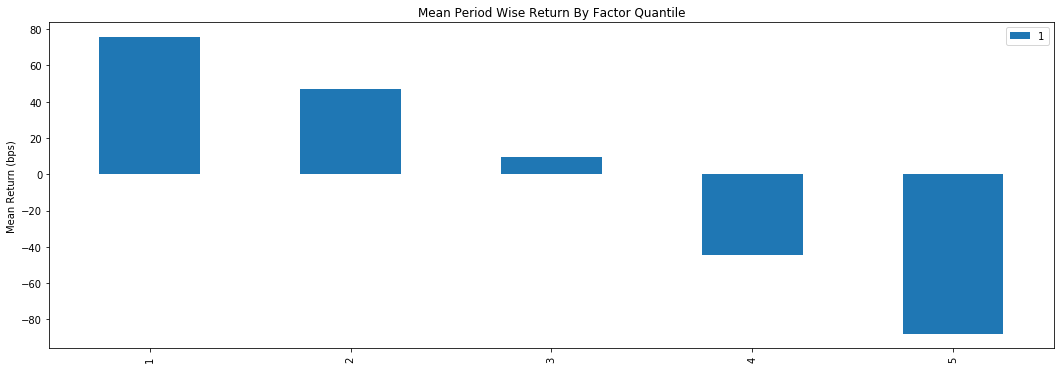

In [29]:
alphalens.plotting.plot_quantile_returns_bar(mean_return_by_q_demeaned)

### 因子分组累计绝对收益净值曲线

In [31]:
mean_return_by_q_monthly, std_err_monthly = alphalens.performance.mean_return_by_quantile(smartq_factor,
                                                                                          by_date=True,
                                                                                          by_group=False,
                                                                                          demeaned=False)
mean_return_by_q_monthly_demeaned, std_err_monthly_demeaned = \
    alphalens.performance.mean_return_by_quantile(smartq_factor,
                                                  by_date=True,
                                                  by_group=False,
                                                  demeaned=True)

In [85]:
mean_return_by_q_monthly.loc[[(1,datetime.datetime(2012,12,31)),(5,datetime.datetime(2012,12,31))]]

,,1
factor_quantile,date,
1,2012-12-31,0.073205
5,2012-12-31,0.069113


In [77]:
mean_return_by_q_monthly_demeaned.head()

1
factor_quantile date                
1               2012-12-31 -0.000451
                2013-01-31  0.001306
                2013-02-28 -0.010298
                2013-03-29 -0.004684
                2013-04-26  0.011555

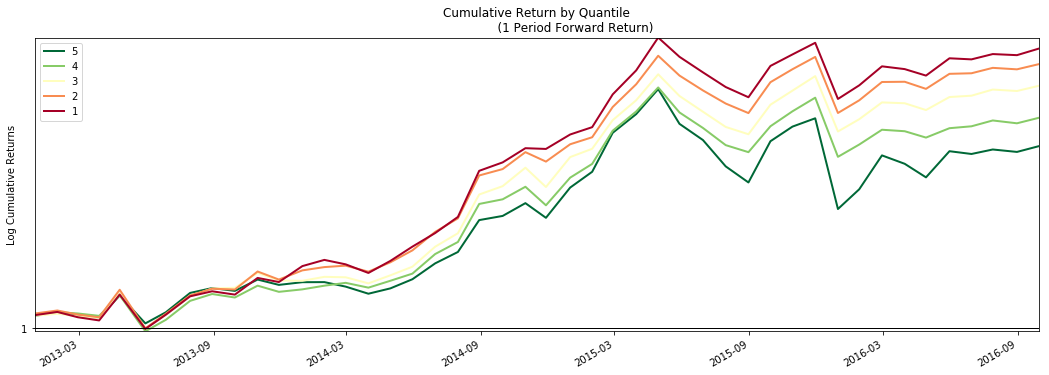

In [32]:
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q_monthly)

### 因子分组累计超额收益净值曲线

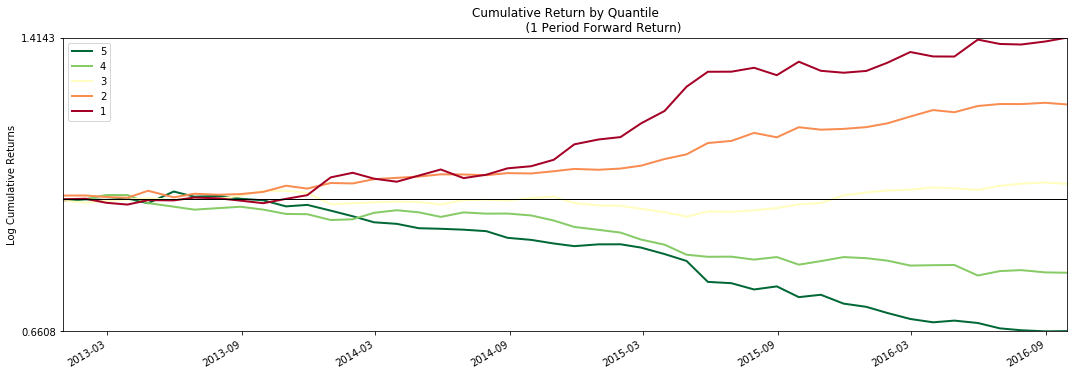

In [33]:
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q_monthly_demeaned)

### 因子收益：因子加权的（多空）累计收益净值曲线

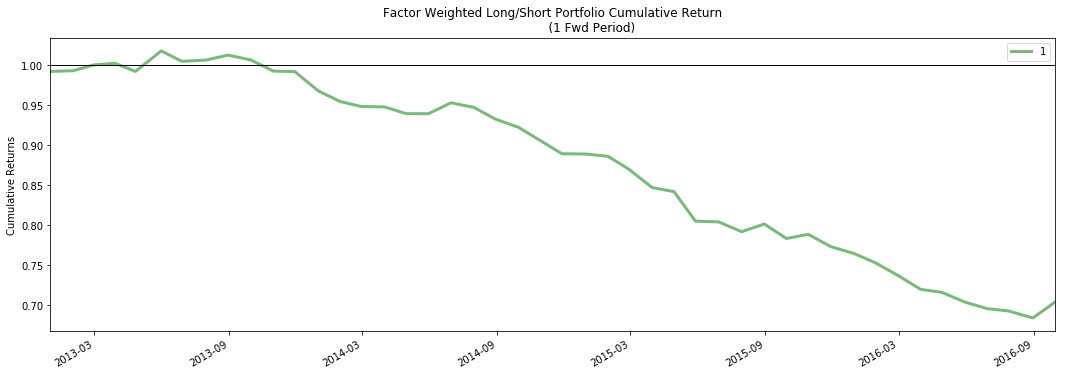

In [107]:
ls_factor_returns = alphalens.performance.factor_returns(smartq_factor)
alphalens.plotting.plot_cumulative_returns(ls_factor_returns)

In [108]:
ls_factor_returns.head()

,1
date,
2012-12-31,-0.008073
2013-01-31,0.000820
2013-02-28,0.007336
2013-03-29,0.002021
2013-04-26,-0.010153


### 多空对冲累计收益净值曲线（非因子加权）

1    2.096298
Name: 2016-09-30 00:00:00, dtype: float64


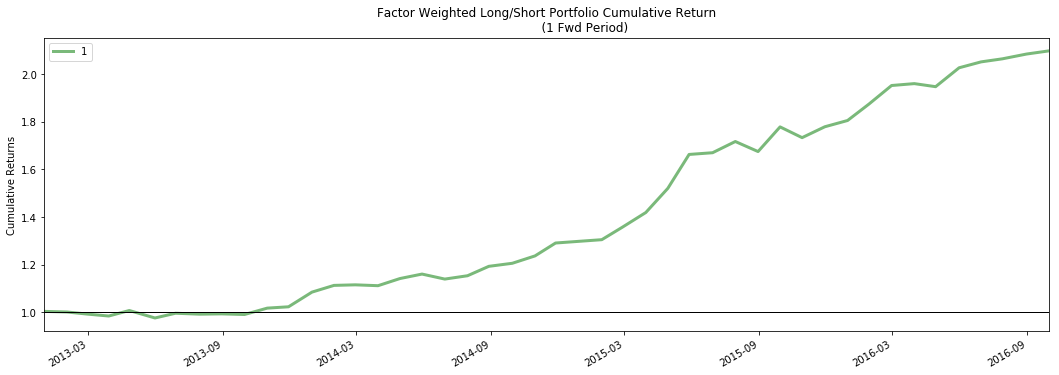

In [98]:
ret_ls = mean_return_by_q_monthly.loc[1] - mean_return_by_q_monthly.loc[5]
rate_ls = ret_ls + 1.0
print(rate_ls.cumprod().iloc[-1])
alphalens.plotting.plot_cumulative_returns(ret_ls)

## 因子IC分析

In [37]:
ic = alphalens.performance.factor_information_coefficient(smartq_factor)

### IC统计表

In [38]:
alphalens.plotting.plot_information_table(ic)

Information Analysis


,1
IC Mean,-0.060
IC Std.,0.080
Risk-Adjusted IC,-0.750
t-stat(IC),-5.087
p-value(IC),0.000
IC Skew,0.159
IC Kurtosis,-0.642


### 因子IC时序图

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1a248fd0>], dtype=object)

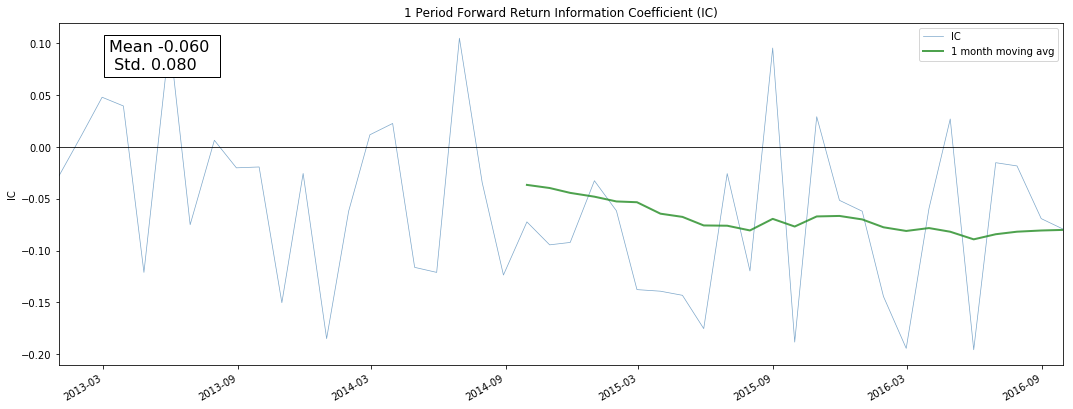

In [39]:
alphalens.plotting.plot_ic_ts(ic)

### 因子IC分布图与QQ图

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1a25ab38>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c2e103cf8>], dtype=object)

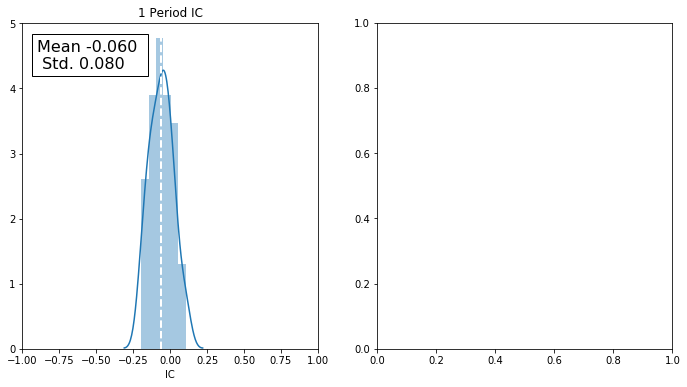

In [40]:
alphalens.plotting.plot_ic_hist(ic)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c35e17710>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c22fe3668>], dtype=object)

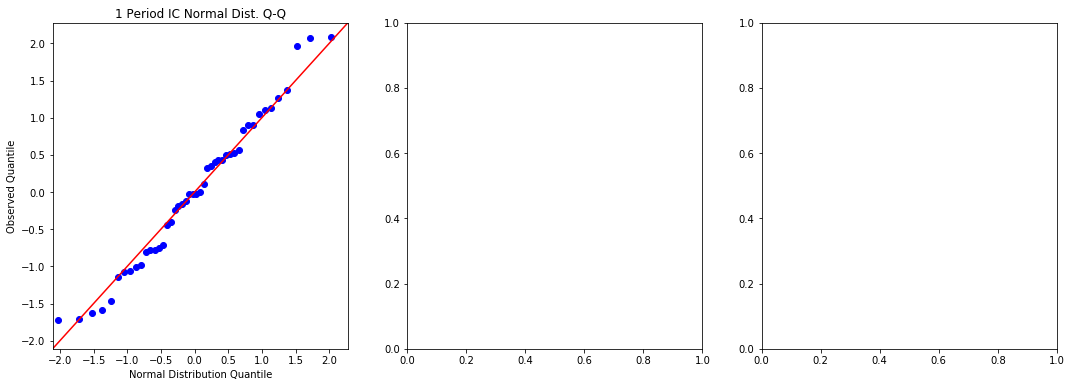

In [41]:
alphalens.plotting.plot_ic_qq(ic)

## 因子换手率分析

Turnover Analysis


,1
Quantile 1 Mean Turnover,0.774
Quantile 2 Mean Turnover,0.794
Quantile 3 Mean Turnover,0.799
Quantile 4 Mean Turnover,0.792
Quantile 5 Mean Turnover,0.776


,1
Mean Factor Rank Autocorrelation,0.068


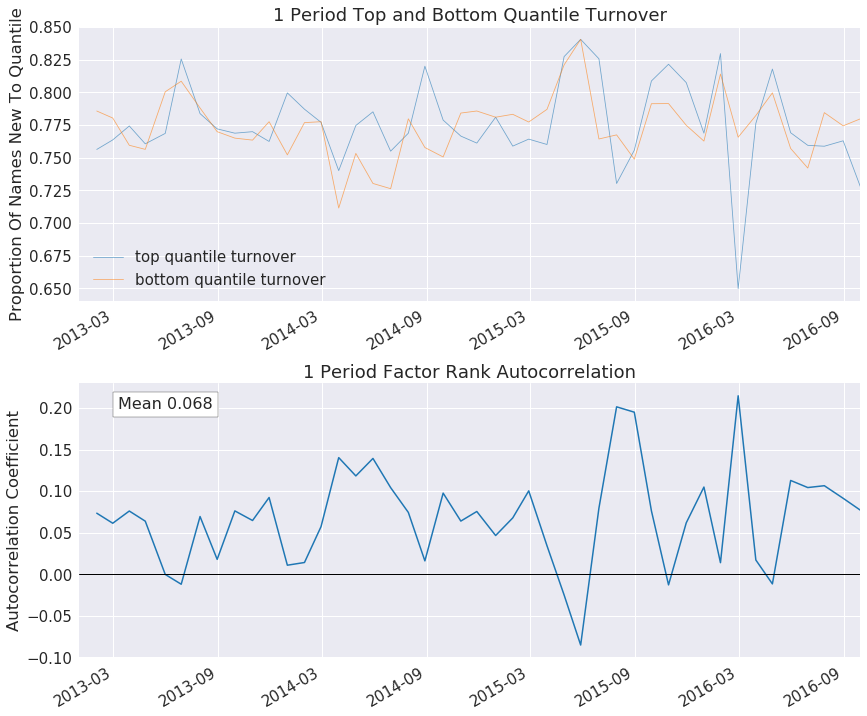

In [42]:
alphalens.tears.create_turnover_tear_sheet(smartq_factor)